## Predictive Customer Analysis - 2

Following the descriptive analysis of the customer purchase on `Positioning_descriptive.ipynb` notebook, here logistic regression and linear regression will be applied will be performed to deepdive into purchase analysis and forecast.

This notebook continues the content of `Positioning_preditive.ipynb`, as it gets longer.

## Libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

import os 
import pickle

## Import the Data

In [25]:
def import_pickle_data(filename) :
    path = os.path.join(os.getcwd(), 'obj_data', filename)
    return pickle.load(open(path, 'rb')) #rb = read as byte datatype

def import_csv(filePath) :
    return pd.read_csv(filePath)

In [26]:
# loading the data file
filePath_purchase = os.path.join(os.getcwd(), 'data', 'purchase data.csv')
df_purchase = import_csv(filePath_purchase)

# importing classes
scaler = import_pickle_data('scaler.pickle')
pca = import_pickle_data('pca.pickle')
kmeans_pca = import_pickle_data('kmeans_pca.pickle')

# standardization
df_purchase.columns.values[-7:] # the 7 features standized 
features_to_include = df_purchase.columns.values[-7:]
df_purchase_std = scaler.transform(df_purchase[features_to_include])

# dimentionality reduction of the standardized data
df_purchase_pca = pca.transform(df_purchase_std)

# segmentation from the preprocessed data
segment_kmeans_pca = kmeans_pca.predict(df_purchase_pca)
df_purchase_analysis = df_purchase.copy()
df_purchase_analysis['Segment'] = segment_kmeans_pca

# binary encoding segment
segment_dummies = pd.get_dummies(df_purchase_analysis['Segment'], 
                                 prefix='Segment', prefix_sep='_')
df_purchase_analysis = pd.concat([df_purchase_analysis, segment_dummies], axis=1)

In [27]:
# Differentiate the dataframe for convenience
df_pa = df_purchase_analysis.copy()

In [28]:
df_pa.head(3)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,47,1,110866,1,0,0,1,0,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,0,1,0,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,0,1,0,0,0


---
## `4.` Brand choice
Earlier, price elasticity was modeled and also when there is a promotion or not. The model had (purchase) `Incidence` as the only dependent variable against the `mean price` as X (predictor variable). 

In the study of brand choice, the logitic regression will also be used  to multiclass problems, i.e. with more than two possible **discrete** outcomes. [Wikipedia](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) explains  that it is a model that is used to predict the probabilities of the different possible outcomes of a categorically(equivalently nominally) distributed dependent variable with **more than two categories**, given **a set of independent variables** (which may be real-valued, binary-valued, categorical-valued, etc.).

In [23]:
df_pa['Brand'].unique() # be careful of 0  = no Incidence to rule out

array([0, 2, 5, 1, 4, 3])

In [30]:
brand_choice = df_pa.query('Incidence == 1').copy()
# brand_choice['Brand'].unique()

In [33]:
# Dependent variable (more than two categories) = Brand
Y = brand_choice['Brand']

In [34]:
# A set of indepent variables = Prices (real-valued)
X = brand_choice.loc[:, brand_choice.columns.str.contains('Price_')]

In [35]:
logit_brand_choice = LogisticRegression(solver='sag', multi_class='multinomial')

In [36]:
logit_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [37]:
logit_brand_choice.coef_

array([[-3.91593412,  0.65846995,  2.41780536,  0.70410279, -0.20207862],
       [ 1.27462274, -1.87985079, -0.21260801, -0.2063331 ,  0.58788329],
       [ 1.62413104,  0.5620829 ,  0.50068016,  1.03946564,  0.45271615],
       [ 0.5745498 ,  0.39559431, -1.40056246, -1.24623538,  0.24936628],
       [ 0.44263054,  0.26370364, -1.30531504, -0.29099996, -1.08788709]])

[Scikit Learn document](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) explains that `coef_` returns ndarray of (n_classes, n_features) where it corresponds to outcome 1 (True) and -coef_ corresponds to outcome 0 (False) for when `multi_class=multinomial`.

So rows represent Brands and columns represent Prices here, which will be transposed in the following :

In [42]:
coef_brand_choice = pd.DataFrame(logit_brand_choice.coef_.T)
coef_brand_choice.columns = ['Brand_' + str(i) for i in range(1, 6)]
coef_brand_choice.index = ['Price_' + str(i) for i in range(1, 6)]

In [43]:
coef_brand_choice

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
Price_1,-3.915934,1.274623,1.624131,0.574550,0.442631
Price_2,0.658470,-1.879851,0.562083,0.395594,0.263704
Price_3,2.417805,-0.212608,0.500680,-1.400562,-1.305315
Price_4,0.704103,-0.206333,1.039466,-1.246235,-0.291000
Price_5,-0.202079,0.587883,0.452716,0.249366,-1.087887


### Findings
It is obvious that Price 1 has a negative coefficient vs choice of Brand 1 but the same relationship does not apply to Brand 3 (in which Price increases does not decrease the choice of Brand 3 - interesting!). 

For better insights, own price brand choice elasticity and cross price brand choice elasticity will be studied in the following sections.

### Own price elasticity - Brand 5

In [46]:
# Create a new range of price to predict PE (price elasticity)
price_range = np.arange(0.5, 3.5, 0.01)

In [50]:
# Creating a empty dataframe with the num_row equal to size of price range
df_own_brand_5 = pd.DataFrame(index=np.arange(price_range.size))

In [54]:
# Having other prices constant than price of Brand 5
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range

In [60]:
# Brand choice in response to price range of Brand 5
predict_bc = logit_brand_choice.predict_proba(df_own_brand_5)
predict_bc.shape

(300, 5)

In [91]:
coef_brand_choice

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
Price_1,-3.915934,1.274623,1.624131,0.574550,0.442631
Price_2,0.658470,-1.879851,0.562083,0.395594,0.263704
Price_3,2.417805,-0.212608,0.500680,-1.400562,-1.305315
Price_4,0.704103,-0.206333,1.039466,-1.246235,-0.291000
Price_5,-0.202079,0.587883,0.452716,0.249366,-1.087887


In [92]:
# Calculate own price elasticity 
beta_5 = coef_brand_choice.iloc[4,4]
PE_own_price_brand_5 = beta_5 * price_range * (1 - predict_bc[:,4])
PE_own_price_brand_5.shape

(300,)

In [93]:
brand_choice_elasticities = pd.DataFrame({'Price_point': price_range, 
                                          'Own_brand_5' : PE_own_price_brand_5})

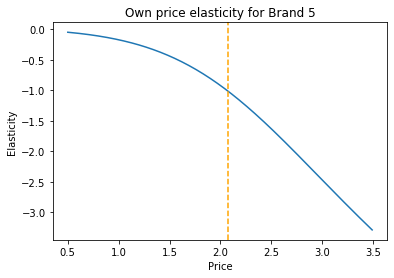

In [106]:
brand_choice_elasticities.plot(x='Price_point', y='Own_brand_5')

plt.title('Own price elasticity for Brand 5')
plt.ylabel('Elasticity')
plt.xlabel('Price')
plt.legend().remove() 
plt.axvline(x=2.07, ls='--', c='orange') # point of inelasticity 
plt.show()

In [99]:
#pd.options.display.max_rows = None
brand_choice_elasticities.iloc[150:160]

,Price_point,Own_brand_5
150,2.00,-0.922793
151,2.01,-0.934926
152,2.02,-0.947154
153,2.03,-0.959477
154,2.04,-0.971893
155,2.05,-0.984402
156,2.06,-0.997005
157,2.07,-1.009700
158,2.08,-1.022487
159,2.09,-1.035365


As price of own price increase, the choice for Brand 5 gradually gets more elastic. Brand 5 becomes elastic after the price point of 2.07, as the graph gets lightly steeper.

### Cross price elasticity - Brand 5, Cross Brand 4
How does the choice for Brand 5 changes as the price of Brand 4 changes, having all other brand prices constant at their means?

In [112]:
# Create a new range of price to predict PE (price elasticity)
price_range = np.arange(0.5, 3.5, 0.01) # 300 x 1 vector
df_cross_brand_4 = pd.DataFrame(index=np.arange(price_range.size))

In [113]:
df_cross_brand_4['Price_1'] = brand_choice['Price_1'].mean()
df_cross_brand_4['Price_2'] = brand_choice['Price_2'].mean()
df_cross_brand_4['Price_3'] = brand_choice['Price_3'].mean()
df_cross_brand_4['Price_4'] = price_range # only Brand 4 price changes within given range
df_cross_brand_4['Price_5'] = brand_choice['Price_5'].mean()

In [125]:
predict_bc_cross = logit_brand_choice.predict_proba(df_cross_brand_4)
predict_bc_cross.shape

(300, 5)

### Formula for Cross price elasticity :
$$𝐸𝑐𝑟𝑜𝑠𝑠 = −Beta(own product) ∗ Price(cross product) ∗ Purchase(cross product)$$

In [128]:
beta_brand_5 = coef_brand_choice.iloc[4,4] # beta of own product (Brand 5)
purchase_cross_4 = predict_bc_cross[:,3]

# Calculate PE 
PE_brand_5_cross_4 = -beta_brand_5 * price_range * purchase_cross_4

In [134]:
brand_choice_elasticities['Cross_4_brand_5'] = PE_brand_5_cross_4

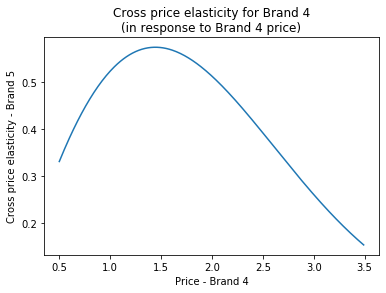

In [142]:
brand_choice_elasticities.plot(x='Price_point', y='Cross_4_brand_5')

plt.title('Cross price elasticity for Brand 4\n(in response to Brand 4 price)')
plt.xlabel('Price - Brand 4')
plt.ylabel('Cross price elasticity - Brand 5')
plt.legend().remove()
plt.show()

Cross price elasticity stays positive across the price range of Brand 4. When elasticity of cross brand > 0, it indicates that the cross brand is a **substitute**.

Although price elasiticty gets descreating after the price point of 1.5, but it still stays positive, meaning the purchase probability of Brand 5 still increases as Price of Brand 5 increases.

So when setting up a marketing strategy for Brand 5, targeting customers choosing Brand 4 to switch to Brand 5 makes sense. **But, it is a laborsome task to target all - therefore it is better off to perform a granular analysis of elasticity by segments.**